In [40]:
pip install pysrt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import datetime
import re
import json
import matplotlib.pyplot as plt

In [42]:
en_file = 'Dataset/Sinners/english.srt'
si_file = 'Dataset/Sinners/sinhala.srt'
output_file = 'Dataset/aligned_subtitles.json'

In [43]:
# ========== Filter Patterns ==========
FILTER_PATTERNS = [
    # English
    r'♪.*?♪', r'♫.*?♫',
    r'\[.*?music.*?\]', r'\[.*?applause.*?\]', r'\[.*?\]',
    r'Directed by', r'Written by', r'Subtitles by', r'Produced by',
    r'www\.\S+', r'\.com', r'\.org', r'@\w+', r'\(.*?\)',

    # Sinhala
    r'♪.*?♪', r'♫.*?♫',
    r'\[.*?සංගීතය.*?\]', r'\[.*?ඇසු සටහන.*?\]', r'\[.*?\]',
    r'අනුවාදනය', r'ඇසුරුම් කළේ', r'සපයනු ලැබුවේ',
    r'සිංහල උපසිරැසි', r'උපසිරැසි ගැන්වීම',
    r'සබැඳි වෙබ් අඩවිය', r'වෙබ් අඩවිය',
    r'www\.\S+', r'\.lk', r'\.com', r'\.org', r'@\w+', r'\(.*?\)',
]

def should_filter(text):
    text = text.strip().lower()
    for pattern in FILTER_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            return True
    return False

# ========== Subtitle Parsing ==========
def parse_time(s):
    return datetime.datetime.strptime(s, "%H:%M:%S,%f").time()

def parse_srt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    pattern = re.compile(
        r'(\d+)\n(\d{2}:\d{2}:\d{2},\d{3}) --> (\d{2}:\d{2}:\d{2},\d{3})\n(.*?)\n(?=\d+\n|\Z)', re.DOTALL)
    subs = []
    for match in pattern.finditer(content):
        index, start, end, text = match.groups()
        cleaned_text = text.replace('\n', ' ').strip()
        if not should_filter(cleaned_text):
            subs.append({
                'index': int(index),
                'start': parse_time(start),
                'end': parse_time(end),
                'text': cleaned_text
            })
    return subs

# ========== Helper Functions ==========
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6

def merge_until_gap(subs, start_idx, max_gap=1.0):
    merged_text = ""
    index = start_idx
    last_end = time_to_seconds(subs[index]['end'])
    merged_text += subs[index]['text'].strip() + " "
    index += 1
    while index < len(subs):
        current_start = time_to_seconds(subs[index]['start'])
        if current_start - last_end > max_gap:
            break
        merged_text += subs[index]['text'].strip() + " "
        last_end = time_to_seconds(subs[index]['end'])
        index += 1
    return merged_text.strip(), start_idx, index, subs[start_idx]['start'], subs[index - 1]['end']

def merge_until_window(subs, start_idx, w_start, w_end):
    merged = ""
    index = start_idx
    while index < len(subs):
        s = time_to_seconds(subs[index]['start'])
        e = time_to_seconds(subs[index]['end'])
        if s > w_end:
            break
        if e >= w_start:
            merged += subs[index]['text'].strip() + " "
        index += 1
    return merged.strip(), start_idx, index, subs[start_idx]['start'], subs[index-1]['end']

def skip_past(subs, idx, time_end):
    while idx < len(subs) and time_to_seconds(subs[idx]['end']) <= time_end:
        idx += 1
    return idx

# ========== Alignment ==========
def align_blocks(en_subs, si_subs):
    en_idx = 0
    si_idx = 0
    aligned = []
    while en_idx < len(en_subs) and si_idx < len(si_subs):
        en_text, _, next_en_idx, en_start, en_end = merge_until_gap(en_subs, en_idx)
        si_text, _, next_si_idx, si_start, si_end = merge_until_gap(si_subs, si_idx)

        en_start_s = time_to_seconds(en_start)
        en_end_s = time_to_seconds(en_end)
        si_start_s = time_to_seconds(si_start)
        si_end_s = time_to_seconds(si_end)

        window_start = min(en_start_s, si_start_s)
        window_end = max(en_end_s, si_end_s)

        merged_en, _, _, _, _ = merge_until_window(en_subs, en_idx, window_start, window_end)
        merged_si, _, _, _, _ = merge_until_window(si_subs, si_idx, window_start, window_end)

        aligned.append({
            "translation": {
                "en": merged_en.strip(),
                "si": merged_si.strip()
            }
        })

        en_idx = skip_past(en_subs, en_idx, window_end)
        si_idx = skip_past(si_subs, si_idx, window_end)

    return aligned

# ========== Post-Filter ==========

def post_filter_remove_empty(aligned_data):
    filtered = []
    removed = []

    for entry in aligned_data:
        en = entry["translation"]["en"].strip()
        si = entry["translation"]["si"].strip()

        if not en or not si:  # Remove if either side is empty
            removed.append(entry)
            continue

        filtered.append(entry)

    print(f"Removed {len(removed)} empty pairs, kept {len(filtered)} pairs.")
    return filtered

def remove_tags(text):
    text = re.sub(r'<.*?>', '', text)  # remove tags like <i>, <b>, etc.
    text = re.sub(r'\s+', ' ', text)   # normalize whitespace
    return text.strip()

def clean_and_format(json_data):

    cleaned_data = []

    for item in json_data:
        en_raw = item['translation'].get('en', '').strip()
        si_raw = item['translation'].get('si', '').strip()

        en_clean = remove_tags(en_raw)
        si_clean = remove_tags(si_raw)

        if en_clean and si_clean:
            cleaned_data.append({
                "en": en_clean,
                "si": si_clean
            })

    print(f"✅ Cleaned {len(cleaned_data)} aligned subtitle pairs.")
    return cleaned_data



In [44]:
# ========== Plot ===============
def plot_word_length_histograms(aligned_data):
    en_lengths = [len(entry["translation"]["en"].split()) for entry in aligned_data]
    si_lengths = [len(entry["translation"]["si"].split()) for entry in aligned_data]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(en_lengths, bins=30, color='skyblue', edgecolor='black')
    plt.title("English Subtitle Word Lengths")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(si_lengths, bins=30, color='salmon', edgecolor='black')
    plt.title("Sinhala Subtitle Word Lengths")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [53]:
# ========== Main ==========
def run_alignment(en_path, si_path, output_path):
    en_subs = parse_srt(en_path)
    si_subs = parse_srt(si_path)

    aligned_data = align_blocks(en_subs, si_subs)
    
    aligned_data = post_filter_remove_empty(aligned_data)
    
    plot_word_length_histograms(aligned_data)
    
    aligned_data = clean_and_format(aligned_data)

    print(f"Aligned {len(aligned_data)} subtitle pairs.")

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(aligned_data, f, ensure_ascii=False, indent=2)
        
    return aligned_data

Removed 0 empty pairs, kept 440 pairs.


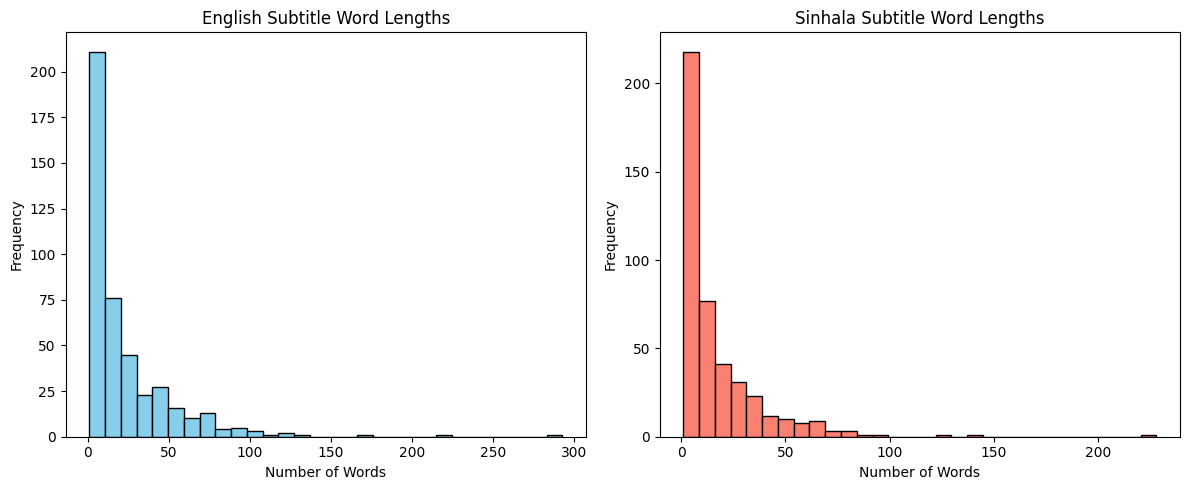

✅ Cleaned 440 aligned subtitle pairs.
Aligned 440 subtitle pairs.
[
  {
    "en": "There are legends of people... born with the gift of making music so true... it can pierce the veil between life and death. Conjuring spirits from the past and the future. In ancient Ireland, they were called Filí.",
    "si": "ජනප්‍රවාද වලට අනුව සමහර මිනිස්සු ඉන්නවා විශේශ සංගීත හැකියාවක් එක්ක ඉපදෙන... ඒ සංගීතෙට පුළුවන්ලු මළවුන්ගේ ලෝකෙට ලඟාවෙන්න. අතීතයේ සහ අනාගතේ ආත්මයන්ට. පුරාණ අයර්ලන්තයේ එයාලට කිව්වේ ෆිලී කියලා."
  },
  {
    "en": "In Choctaw land, they call them firekeepers. And in West Africa... they're called griots. This gift can bring healing to their communities... but it also attracts evil.",
    "si": "චොක්ටෝ දේශයේ එයාලට කියන්නේ ෆයර්කීපර්ස් කියලා. බටහිර අප්‍රිකාවේ එයාලට කියන්නේ ග්‍රියට්ස් කියලා. මේ හැකියාව එයාලගේ ප්‍රජාවට සුවය ගෙන එනවා... ඒත් ඒකට තව අඳුරු බලවේගද ආකර්ෂණේ වෙනවා."
  },
  {
    "en": "-Sammie! -Ruthie. No, no.",
    "si": "සැමී! - රූති. නෑ, නෑ."
  },
  {
    "en": "Come on, son.",

In [54]:
aligned_data = run_alignment(en_file, si_file, output_file)
print(json.dumps(aligned_data, ensure_ascii=False, indent=2))